In [16]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
datasets = {
    "Eliot": 53, # Iris
    "Ethel": 728, # 
    "Leo": 878, # Cirrhosis
    "Adair": 109, # Wine
}


In [17]:
dataset = fetch_ucirepo(id=datasets["Eliot"])
# obtenemos los datos
X = dataset.data.features 
y = dataset.data.targets 
df = pd.DataFrame(X, columns=dataset.data.feature_names)
df['target'] = y

In [18]:
df = df.dropna()

In [19]:
def separate_dataframe(df):
    vector_x = df.drop(df.columns[-1], axis=1) 
    vector_y = df[df.columns[-1]]
    return vector_x, vector_y

In [20]:
vector_x, vector_y = separate_dataframe(df)

In [21]:
vector_x = vector_x.select_dtypes(include=['int64', 'float64'])

In [22]:
vector_x.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [23]:
vector_y.head()

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: target, dtype: object

----
# MODELOS

In [24]:
def min_distance_classifier(train_x, train_y, test_x):
    # Calcular el promedio de cada clase en el conjunto de entrenamiento
    class_means = train_x.groupby(train_y).mean()

    # Clasificar cada observación en el conjunto de prueba
    predicted_y = []
    for _, row in test_x.iterrows():
        min_dist = float('inf')
        min_class = None
        for cls, mean in class_means.iterrows():
            dist = np.linalg.norm(row - mean)
            if dist < min_dist:
                min_dist = dist
                min_class = cls
        predicted_y.append(min_class)

    return predicted_y


In [25]:
def knn_classifier(train_x, train_y, test_x, k=1):
    predicted_y = []
    for _, test_row in test_x.iterrows():
        # Calcular la distancia a cada punto en el conjunto de entrenamiento
        distances = np.linalg.norm(train_x - test_row, axis=1)
        # Obtener los índices de los k vecinos más cercanos
        nearest_neighbors = np.argsort(distances)[:k]
        # Votación mayoritaria
        votes = train_y.iloc[nearest_neighbors].mode()
        predicted_y.append(votes.values[0])

    return predicted_y



----
# IMPLEMENTACION DE GRAFICOS
----


In [26]:
import matplotlib.pyplot as plt


In [34]:
def train_test_split(data_x, data_y, test_size=0.2):
    test_indices = np.random.choice(data_x.index, size=int(len(data_x) * test_size), replace=False)
    train_x = data_x.drop(test_indices)
    train_y = data_y.drop(test_indices)
    test_x = data_x.loc[test_indices]
    test_y = data_y.loc[test_indices]
    return train_x, train_y, test_x, test_y

In [35]:
def evaluate_model_with_plot(classifier, data_x, data_y, test_size=0.2, title="Model Evaluation"):
    train_x, train_y, test_x, test_y = train_test_split(data_x, data_y, test_size)
    predicted_y = classifier(train_x, train_y, test_x)
    accuracy = sum(predicted_y == test_y) / len(test_y)
    error_rate = 1 - accuracy

    # Visualización
    plt.bar(['Accuracy', 'Error Rate'], [accuracy, error_rate], color=['blue', 'red'])
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('Percentage')
    plt.show()

    return accuracy, error_rate

In [37]:
def k_fold_cross_validation_with_plot(classifier, data_x, data_y, k=5):
    fold_size = int(len(data_x) / k)
    accuracies = []
    for i in range(k):
        test_indices = range(i * fold_size, (i + 1) * fold_size)
        train_indices = list(set(range(len(data_x))) - set(test_indices))

        train_x, train_y = data_x.iloc[train_indices], data_y.iloc[train_indices]
        test_x, test_y = data_x.iloc[test_indices], data_y.iloc[test_indices]

        predicted_y = classifier(train_x, train_y, test_x)
        accuracy = sum(predicted_y == test_y) / len(test_y)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    error_rate = 1 - mean_accuracy

    # Visualización
    plt.plot(range(1, k+1), accuracies, marker='o', color='blue', label='Accuracy per Fold')
    plt.axhline(y=mean_accuracy, color='green', linestyle='-', label='Mean Accuracy')
    plt.title('K-Fold Cross Validation')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

    return mean_accuracy, error_rate


In [39]:
def bootstrap_validation_with_plot(classifier, data_x, data_y, n_iterations=100, sample_size=None):
    if sample_size is None:
        sample_size = len(data_x)

    accuracies = []
    for _ in range(n_iterations):
        sample_indices = np.random.choice(data_x.index, size=sample_size, replace=True)
        out_of_bag_indices = list(set(data_x.index) - set(sample_indices))

        train_x, train_y = data_x.loc[sample_indices], data_y.loc[sample_indices]
        test_x, test_y = data_x.loc[out_of_bag_indices], data_y.loc[out_of_bag_indices]

        predicted_y = classifier(train_x, train_y, test_x)
        accuracy = sum(predicted_y == test_y) / len(test_y)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    error_rate = 1 - mean_accuracy

    # Visualización
    plt.hist(accuracies, bins=10, color='blue', alpha=0.7)
    plt.axvline(x=mean_accuracy, color='green', linestyle='--', label='Mean Accuracy')
    plt.title('Bootstrap Validation')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return mean_accuracy, error_rate


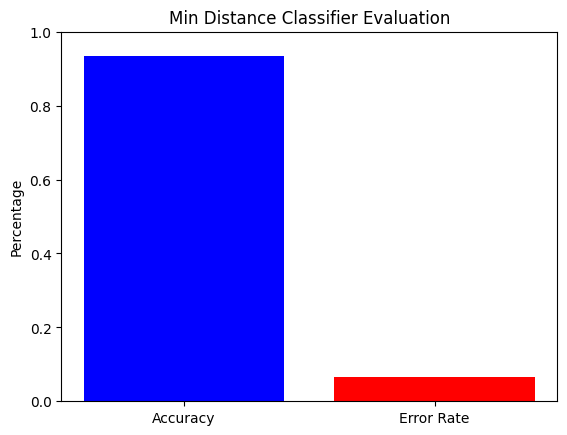

Accuracy: 0.9333333333333333 | Error Rate: 0.06666666666666665


In [42]:
# Suponiendo que vector_x y vector_y son tus DataFrames de características y etiquetas
accuracy, error_rate = evaluate_model_with_plot(min_distance_classifier, vector_x, vector_y, test_size=0.2, title="Min Distance Classifier Evaluation")
print(f"Accuracy: {accuracy} | Error Rate: {error_rate}")


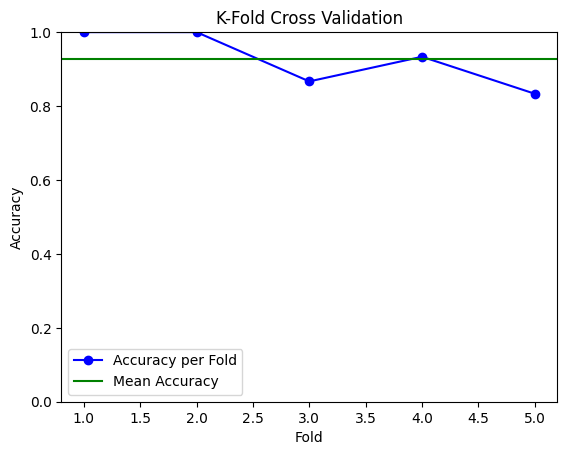

(0.9266666666666665, 0.07333333333333347)

In [41]:
k_fold_cross_validation_with_plot(knn_classifier, vector_x, vector_y, k=5)


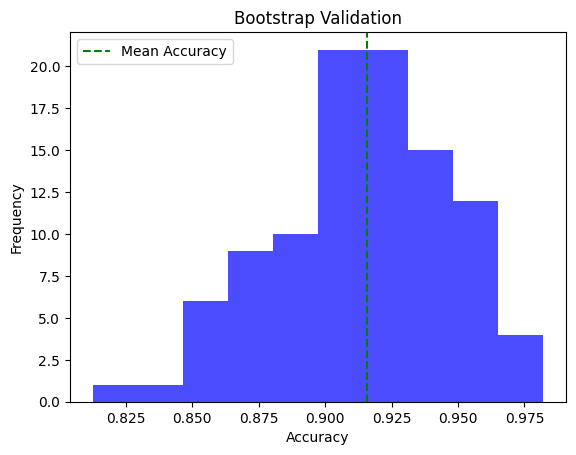

(0.9157320600980228, 0.08426793990197723)

In [43]:
bootstrap_validation_with_plot(min_distance_classifier, vector_x, vector_y, n_iterations=100)
